## 데이터 분석

### import

In [1]:
import cv2
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

### 데이터 탐색

In [2]:
# 데이터 경로
data_path = './data/'

train = pd.read_csv(data_path + 'train.csv')
test = pd.read_csv(data_path + 'test.csv')
submission = pd.read_csv(data_path + 'sample_submission.csv')

In [3]:
train.shape, test.shape

((1821, 5), (1821, 1))

In [4]:
train.head()

image_id  healthy  multiple_diseases  rust  scab
0  Train_0        0                  0     0     1
1  Train_1        0                  1     0     0
2  Train_2        1                  0     0     0
3  Train_3        0                  0     1     0
4  Train_4        1                  0     0     0

In [5]:
test.head()

image_id
0   Test_0
1   Test_1
2   Test_2
3   Test_3
4   Test_4

In [6]:
submission.head()

image_id  healthy  multiple_diseases  rust  scab
0   Test_0     0.25               0.25  0.25  0.25
1   Test_1     0.25               0.25  0.25  0.25
2   Test_2     0.25               0.25  0.25  0.25
3   Test_3     0.25               0.25  0.25  0.25
4   Test_4     0.25               0.25  0.25  0.25

### 데이터 시각화

- 타깃값 분포

In [7]:
# 데이터를 타깃값 별로 추출
healthy = train[train['healthy'] == 1]
multiple_diseases = train[train['multiple_diseases'] == 1]
rust = train[train['rust'] == 1]
scab = train[train['scab'] == 1]

- 파이 차트

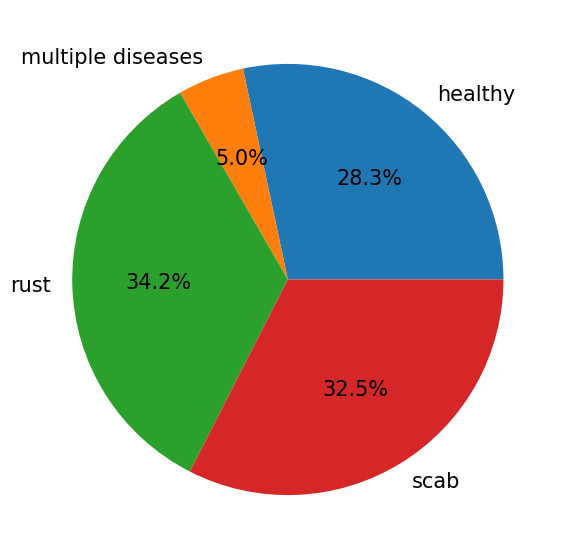

In [8]:
mpl.rc('font', size = 15)
plt.figure(figsize = (7, 7))

label = ['healthy', 'multiple diseases', 'rust', 'scab'] # 타깃값 레이블
# 타깃값 분포 파이 그래프
plt.pie([len(healthy), len(multiple_diseases), len(rust), len(scab)], 
        labels = label, 
        autopct = '%.1f%%');

> - 위의 파이 차트에서 우리는 데이터셋의 대부분의 잎이 건강하지 않음을 알 수 있습니다 (71.7%).
> - 식물 중에서는 다중 질병을 가진 것이 5%에 불과하며, "rust"와 "scab"은 파이의 약 1/3를 차지하고 있다는 것을 알 수 있습니다.

- 이미치 출력

In [9]:
def show_image(img_ids, rows = 2, cols = 3):
    # assert문은 조건이 True가 아니면 코드의 실행을 중단시키고 예외를 발생시키는 구문 
    assert len(img_ids) <= rows*cols # 이미지가 행/열 개수보다 많으면 오류

    plt.figure(figsize = (15, 8))         # 전체 Figure 크기 설정
    grid = gridspec.GridSpec(rows, cols)  # 서브플롯 배치

    # 이미지 출력
    for idx, img_id in enumerate(img_ids):
        img_path = f'{data_path}images/{img_id}.jpg'   # 이미지 파일 경로 
        image = cv2.imread(img_path)                   # 이미지 파일 읽기 
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # 이미지 색상 보정 
        ax = plt.subplot(grid[idx])                    # 만들었던 서브플롯 불러오기
        ax.axis('off') 
        ax.imshow(image) # 이미지 출력

In [10]:
# 각 타깃값별 image_id(마지막 6개)
num_of_imgs = 6
last_healthy_img_ids = healthy['image_id'][-num_of_imgs:]
last_multiple_diseases_img_ids = multiple_diseases['image_id'][-num_of_imgs:]
last_rust_img_ids = rust['image_id'][-num_of_imgs:]
last_scab_img_ids = scab['image_id'][-num_of_imgs:]

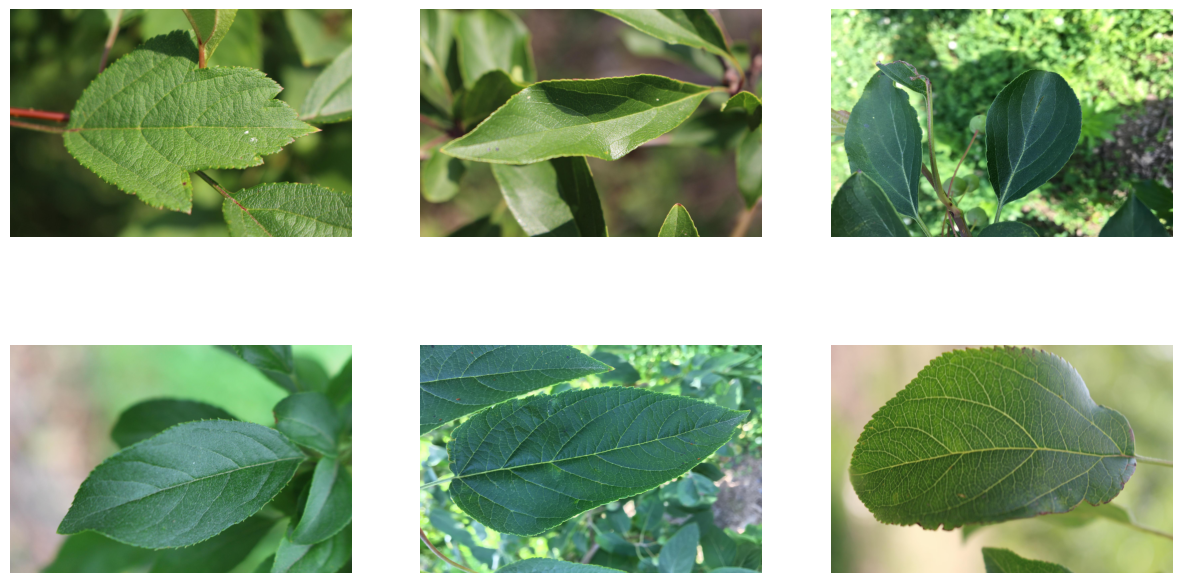

In [11]:
show_image(last_healthy_img_ids) # 건강한 잎사귀 출력

> - 건강한 잎은 완전히 녹색이며, 갈색/노란색 반점이나 상처가 없음을 알 수 있습니다

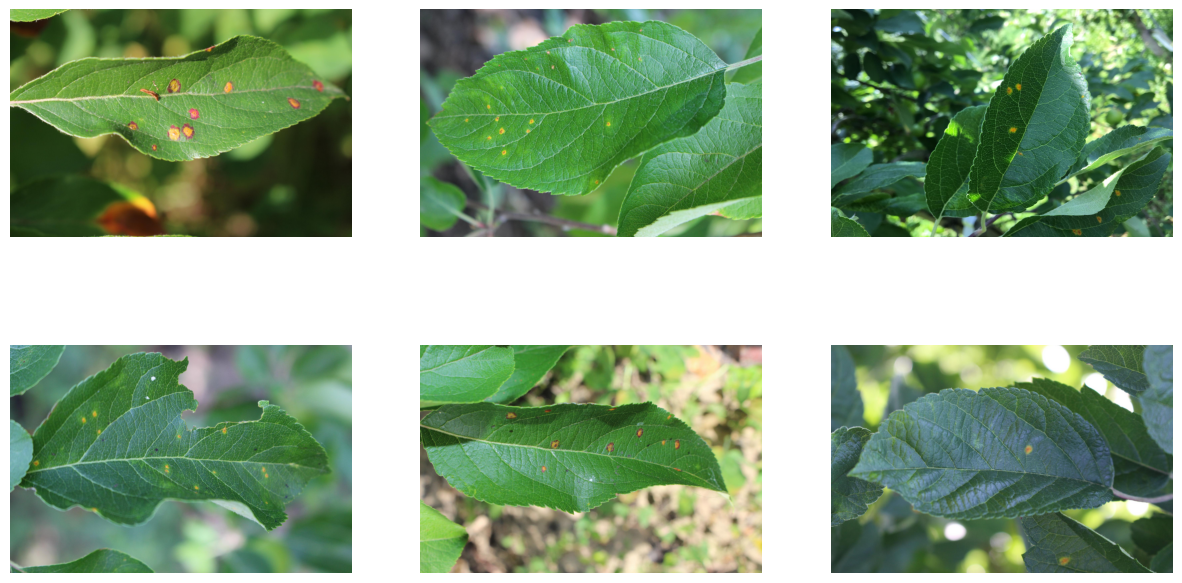

In [13]:
show_image(last_rust_img_ids) # rust 상태의 잎사귀 출력

> - 잎 전체에 갈색과 노란색으로 된 여러 반점이 있는 것을 볼 수 있습니다.
>   - rust : "곡물과 기타 풀에 특히 나타나는 질병으로, 감염된 잎날과 잎집에서 녹색의 농포 형태로 된 스포어가 생기는 것으로 특징짓고 여러 가지 곰팡이에 의해 발생하는 질병"으로 정의

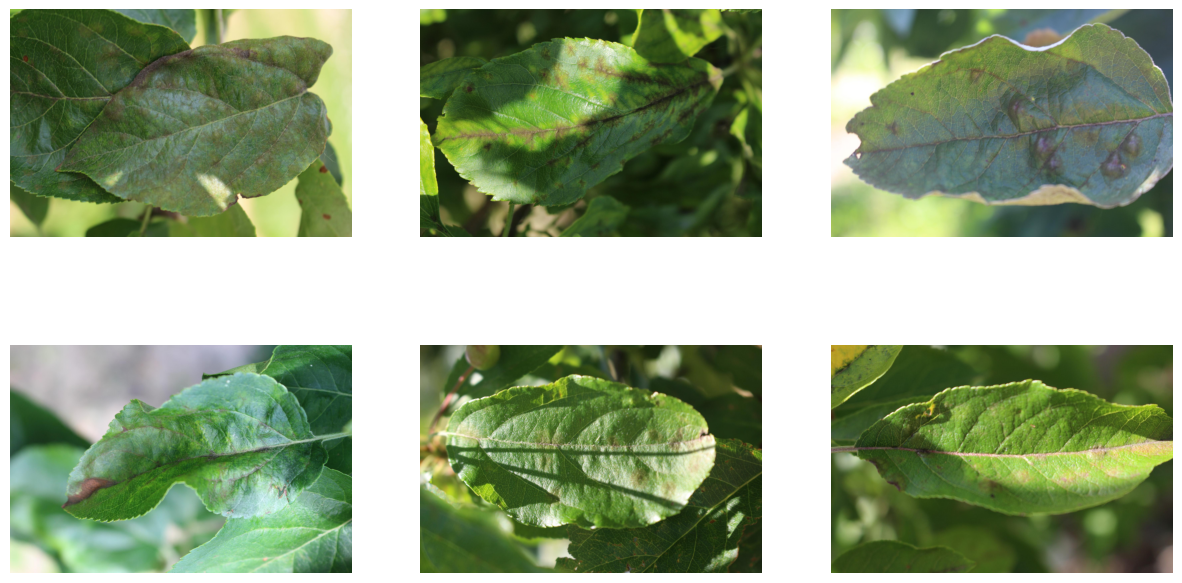

In [14]:
show_image(last_scab_img_ids) # scab 상태의 잎사귀

> - 잎 전체에 큰 갈색 자국과 얼룩이 있는 것을 볼 수 있습니다.
>   - scab : "곰팡이나 세균에 의해 발생하며 과일, 잎 또는 뿌리에 표면과 다른 색의 반점을 일으키는 여러 식물 질병 중 하나"로 정의

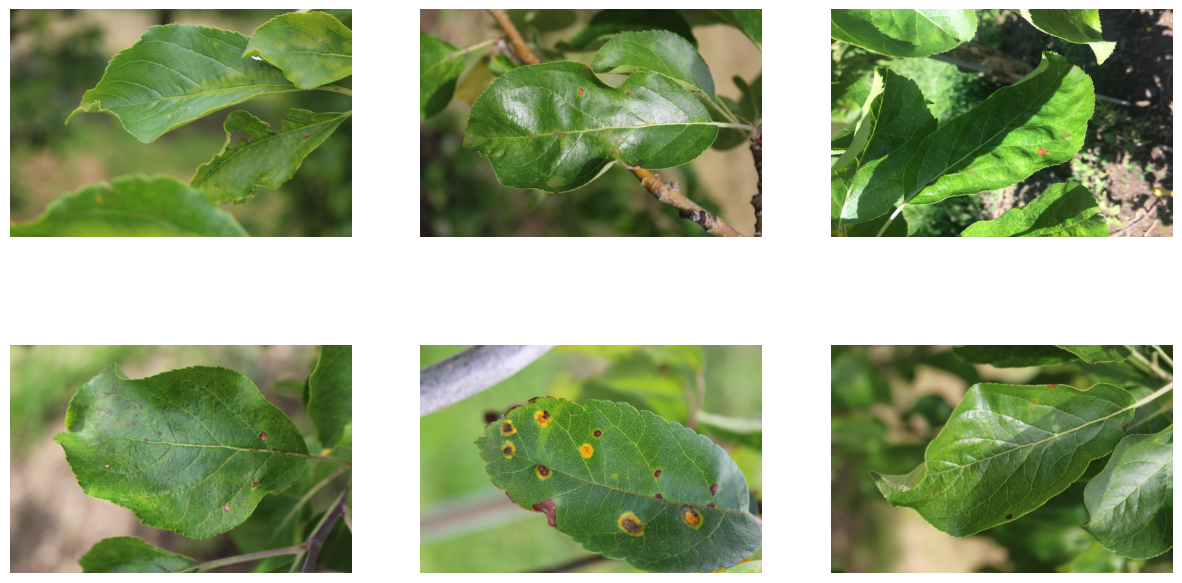

In [ ]:
show_image(last_multiple_diseases_img_ids) # 여러 질병에 걸린 잎사귀 출력

> - 잎이 갈색 자국과 노란 반점 등 여러 질병의 증상을 나타내는 것을 볼 수 있습니다. 이 식물들은 위에서 설명한 질병들 두가지를 모두 가지고 있습니다.

## 베이스라인 모델

### import

In [15]:
import numpy as np
import pandas as pd
import tensorflow as tf
import plotly.graph_objects as go
import tensorflow.keras.layers as L

from tqdm import tqdm
from sklearn.model_selection import KFold
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping

tqdm.pandas()
np.random.seed(42)
tf.random.set_seed(42)

### 상수

In [16]:
SEED = 42
BATCH_SIZE = 4
EPOCHS = 50
FOLD = 5

AUTO = tf.data.experimental.AUTOTUNE

IMAGE_PATH = "./data/images/"
TEST_PATH = "./data/test.csv"
TRAIN_PATH = "./data/train.csv"
SUB_PATH = "./data/sample_submission.csv"


> - ``` tf.data.experimental.AUTOTUNE``` 
>   - TensorFlow 데이터셋 API의 성능 향상 기능을 활성화하는 상수
>   - 이 값은 데이터셋 작업의 실행 순서를 자동으로 조정하여 데이터를 효율적으로 로드하고 처리하는 것을 도와줌
>   - AUTOTUNE을 사용하면 데이터 전처리 및 모델 학습 시간을 최적화할 수 있습니다.

### 데이터 준비

- 데이터 불러오기

In [17]:
sub = pd.read_csv(SUB_PATH)
test_data = pd.read_csv(TEST_PATH)
train_data = pd.read_csv(TRAIN_PATH)

In [18]:
# image_id열의 값들을 이미지 파일 경로로 바꿔주기 위한 함수
def format_path(name):
    return IMAGE_PATH + name + '.jpg'

# DataFrame의 형태를 array 형태로 바꿔 주기 위해 .values와 np.float32를 사용
test_paths = test_data['image_id'].apply(format_path).values
train_paths = train_data['image_id'].apply(format_path).values
train_labels = np.float32(train_data.loc[:, 'healthy':'scab'].values)

- 데이터 전처리

In [19]:
def decode_image(filename, label=None, image_size=(512, 512)):
    bits = tf.io.read_file(filename)                    # 파일을 바이트 스트링으로 읽어옵니다.
    image = tf.image.decode_jpeg(bits, channels=3)      # 컬러 이미지(channels=3)로 디코딩
    image = tf.cast(image, tf.float32) / 255.0          # 디코딩된 이미지를 float형으로 변환하고 정규화
    image = tf.image.resize(image, image_size)          # 이미지 크기 조정
    
    # label이 None이면 이미지만 반환, 그렇지 않으면 이미지와 label을 함께 반환
    if label is None:
        return image
    else:
        return image, label

def data_augment(image, label=None, seed=SEED):
    image = tf.image.random_flip_left_right(image)      # 이미지를 좌우로 무작위로 뒤집기.
    image = tf.image.random_flip_up_down(image)         # 이미지를 상하로 무작위로 뒤집기.
    
    if label is None:
        return image
    else:
        return image, label

In [20]:
def get_training_dataset(train_paths,train_labels):

    # 입력 데이터를 슬라이스하여 데이터셋을 생성
    dataset = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))

    # map() 메서드를 사용해 이미지 디코딩 및 전처리를 수행합니다.
    # num_parallel_calls은 데이터셋의 변환 연산을 병렬로 처리하는 데 사용되는 스레드 수를 나타냅니다.
    dataset = dataset.map(decode_image, num_parallel_calls=AUTO)

    # map() 메서드를 사용해 데이터 증강을 수행합니다.
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)

    # 데이터셋을 반복적으로 사용하기 위한 메서드
    dataset = dataset.repeat()

    # 데이터셋을 섞습니다.
    dataset = dataset.shuffle(512)

    # 배치 크기에 맞게 데이터셋을 배치로 구성합니다.
    dataset = dataset.batch(BATCH_SIZE)
    
    # 학습 중에 다음 배치를 사전에 로드하여 속도를 높입니다.
    dataset = dataset.prefetch(AUTO)
    
    return dataset

def get_validation_dataset(valid_paths,valid_labels):
    dataset = tf.data.Dataset.from_tensor_slices((valid_paths, valid_labels))
    dataset = dataset.map(decode_image, num_parallel_calls=AUTO)
    dataset = dataset.cache()           # 데이터셋을 캐시에 저장합니다.
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) 
    return dataset

def get_test_dataset(test_paths):
    dataset = tf.data.Dataset.from_tensor_slices(test_paths)
    dataset = dataset.map(decode_image, num_parallel_calls=AUTO)
    dataset = dataset.batch(BATCH_SIZE)
    return dataset

### 모델 구성하기

In [21]:
def build_lrfn(lr_start=0.00001,        # 초기 학습률
               lr_max=0.00005,          # 최대 학습률
               lr_min=0.00001,          # 최소 학습률
               lr_rampup_epochs=5,      # 학습률 증가 기간
               lr_sustain_epochs=0,     # 학습률 유지 기간
               lr_exp_decay=.8):        # 학습률 감소 지수

    def lrfn(epoch):

        # epoch가 학습률 증가 기간보다 작은경우
        if epoch < lr_rampup_epochs:
            # 학습률은 선형적으로 초기 학습률에서 최대 학습률까지 증가합니다.
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start

        # epoch가 학습률 증가 기간과 학습률 증가 기간과 유지기간의 합 사이인 경우 
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            # 학습률은 최대 학습률로 유지 됩니다.
            lr = lr_max

        # epoch가 학습률 증가 기간보다 큰경우
        else:
            # 지수적으로 감소하며, 학습률 감소 지수를 이용하여 계산됩니다.
            # 이를 통해 학습률이 지속적으로 작아지는 형태를 가집니다.
            lr = (lr_max - lr_min) *\
                 lr_exp_decay**(epoch - lr_rampup_epochs\
                                - lr_sustain_epochs) + lr_min
        return lr
    return lrfn

lrfn = build_lrfn()
# LearningRateScheduler 콜백은 주어진 함수를 이용하여 학습률을 업데이트하는 역할을 합니다.
# verbose = 1은 epoch의 시작 시 학습률 스케줄링 정보를 출력합니다.
lr_schedule = LearningRateScheduler(lrfn, verbose=1)

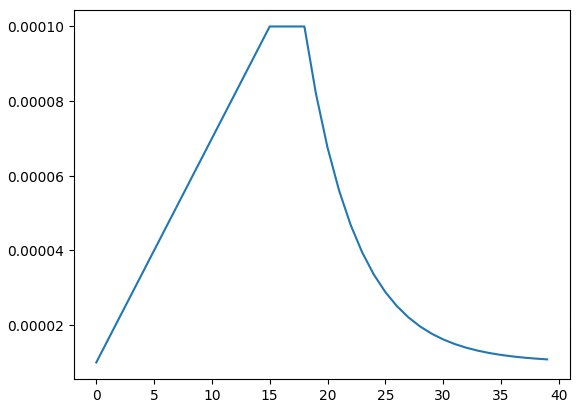

In [22]:
def get_model(): # DenseNet 학습 모델 정의
    model = tf.keras.Sequential([DenseNet121(input_shape=(512, 512, 3), # DenseNet121 전이학습
                                        weights='imagenet',             # imagent이 학습한 가중치 
                                        include_top=False),             # 분류 학습을 하지 않음
                            L.GlobalAveragePooling2D(),                 # 2차원 만큼 차원 줄이기
                            L.Dense(train_labels.shape[1],              # softmax 활성화 함수로 출력
                                    activation='softmax')])
        
    model.compile(optimizer='adam',                                    # adam 함수로 최적화
                loss = 'categorical_crossentropy',                     # 다항분류에 쓰이는 categorical_crossentropy
                metrics=['categorical_accuracy'])                      # 모텔 수행결과에 다항분류 정확도 출력
    
    return model

get_model().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 16, 16, 1024)      7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 4)                 4100      
                                                                 
Total params: 7,041,604
Trainable params: 6,957,956
Non-trainable params: 83,648
_________________________________________________________________


### DenseNet 모델 학습  

In [23]:
STEPS_PER_EPOCH = train_labels.shape[0] // BATCH_SIZE    #한번의 에포크에 훈련할 배치 개수(훈련샘플수/배치사이즈)
histories = []                                           #모델 훈련 결과값 저장 
probs = []                                               #모델 예측 결과값 저장       
auc_score = []
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5) # 검증셋오차(val_loss)가 5번이상 낮아지지않으면 학습 멈춤
kfold = KFold(FOLD , shuffle = True, random_state = SEED) # KFold함수 호출 FOLD 개의 학습셋,데스트셋 분리
i = 1                                                     # 샘플이 한쪽에 치우치지 않도록 shuffle 옵션 True

for train_idx, val_idx in kfold.split(train_paths,train_labels): # train_paths, labels를 k개로 나눈다
        print(); print('#'*25)
        print('### FOLD',i)                      # 현재 몇번째 학습셋인지 표시
        print('#'*25)

        trn_paths = train_paths[train_idx]        # 나뉘어진 학습셋들의 데이터를 저장                
        val_paths = train_paths[val_idx]
        trn_labels = train_labels[train_idx]
        val_labels = train_labels[val_idx]
        
        model = get_model()                     # DenseNet 모델 호출

        history = model.fit(get_training_dataset(trn_paths, trn_labels),   #  train 데이터셋 지정   
                            epochs=EPOCHS,                                 #  학습 반복 횟수
                            callbacks=[lr_schedule, early_stopping],       #  lrfn 학습속도 와 early_stopping 출력 
                            steps_per_epoch=STEPS_PER_EPOCH,               
                            validation_data=get_validation_dataset(val_paths, val_labels)) #검증 데이터셋 지정
        
        i+=1                                                          # 다음 학습셋 표시

        prob = model.predict(get_test_dataset(test_paths), verbose=1) # 모델 예측 , verbose=1 : 결과 표시
        probs.append(prob)                                            # 모델 예측값 저장 
        histories.append(history)                                     # 모델 학습값 저장


#########################
### FOLD 1
#########################

Epoch 1: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/50
455/455 [==============================] - 104s 197ms/step - loss: 1.0036 - categorical_accuracy: 0.5956 - val_loss: 0.5071 - val_categorical_accuracy: 0.8521 - lr: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.8000000000000004e-05.
Epoch 2/50
455/455 [==============================] - 91s 201ms/step - loss: 0.5274 - categorical_accuracy: 0.8225 - val_loss: 0.2308 - val_categorical_accuracy: 0.9260 - lr: 1.8000e-05

Epoch 3: LearningRateScheduler setting learning rate to 2.6000000000000002e-05.
Epoch 3/50
455/455 [==============================] - 94s 207ms/step - loss: 0.3945 - categorical_accuracy: 0.8637 - val_loss: 0.1767 - val_categorical_accuracy: 0.9370 - lr: 2.6000e-05

Epoch 4: LearningRateScheduler setting learning rate to 3.4000000000000007e-05.
Epoch 4/50
455/455 [==============================] - 94s 208ms/step -

### 결과 저장

In [24]:
prob_sum = 0
for prob in probs:                                  # 모델 예측값 합산
    prob_sum += prob
prob_avg = prob_sum/FOLD                            # 모델 예측값 평균 계산
sub.loc[:, 'healthy':] = prob_avg
sub.to_csv('./data/submission_dnn2.csv', index=False) # kfold 결과값 csv파일로 저장
sub.head()

image_id   healthy  multiple_diseases      rust      scab
0   Test_0  0.000385           0.021912  0.977337  0.000366
1   Test_1  0.000143           0.004316  0.994290  0.001251
2   Test_2  0.000131           0.000094  0.000344  0.999431
3   Test_3  0.992204           0.000142  0.003904  0.003750
4   Test_4  0.000006           0.024423  0.975265  0.000306

### 결과 시각화

In [58]:
def display_graph(histories, yaxis):

    plt.figure(figsize=(30, 15))

    if yaxis == "loss":

        for idx, history in enumerate(histories):
            # y_vloss에 테스트셋의 오차 저장
            y_vloss = history.history['val_loss']

            # y_loss에 학습셋의 오차 저장
            y_loss = history.history['loss']

            x_len = np.arange(len(y_loss))

            plt.subplot(2, 3, idx+1)
            plt.plot(x_len, y_vloss, marker='.', c="red", label='val_loss')
            plt.plot(x_len, y_loss, marker='.', c="blue", label='loss')

            plt.title(f"fold : {idx+1}")
            plt.legend(loc='best')
            plt.grid()
            plt.xlabel('epoch')
            plt.ylabel('loss')

        plt.show()
        
    else:

        for idx, history in enumerate(histories):

            # y_vloss에 테스트셋의 정확도 저장
            y_vloss = history.history['categorical_accuracy']

            # y_loss에 학습셋의 정확도 저장
            y_loss = history.history['val_categorical_accuracy']

            x_len = np.arange(len(y_loss))

            plt.subplot(2, 3, idx+1)
            plt.plot(x_len, y_vloss, marker='.', c="red", label='val_accuracy')
            plt.plot(x_len, y_loss, marker='.', c="blue", label='accuracy')

            plt.title(f"fold : {idx+1}")
            plt.legend(loc='best')
            plt.grid()
            plt.xlabel('epoch')
            plt.ylabel('accuracy')

        plt.show()        

- 손실값(loss) 그래프

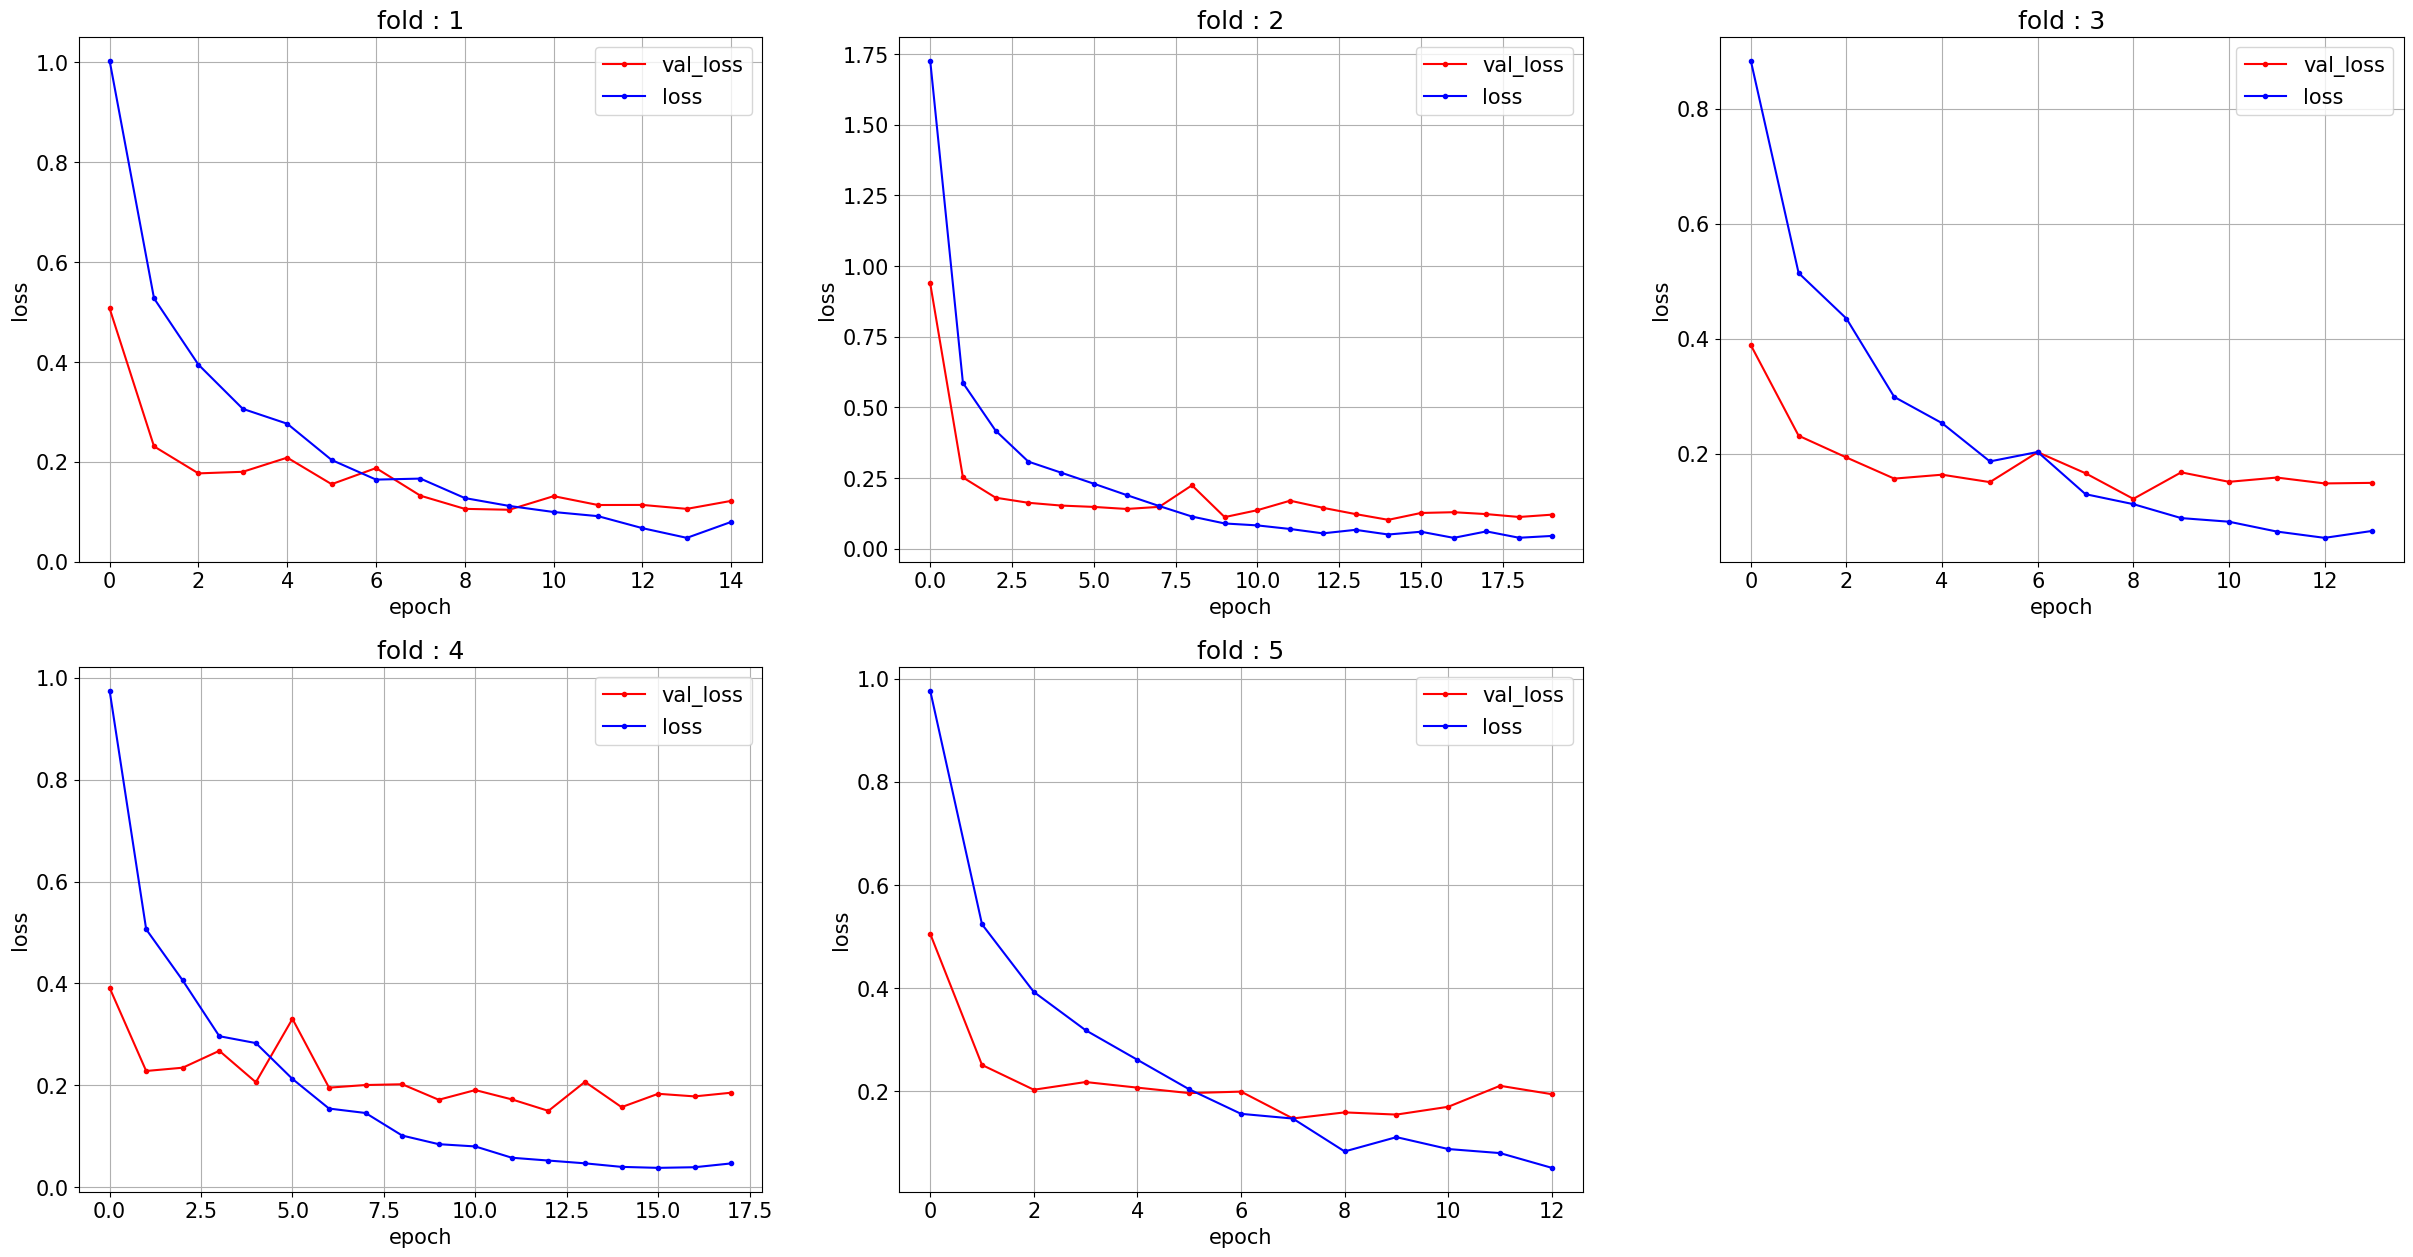

In [59]:
display_graph(histories, 'loss')

- 정확도(accuracy) 그래프

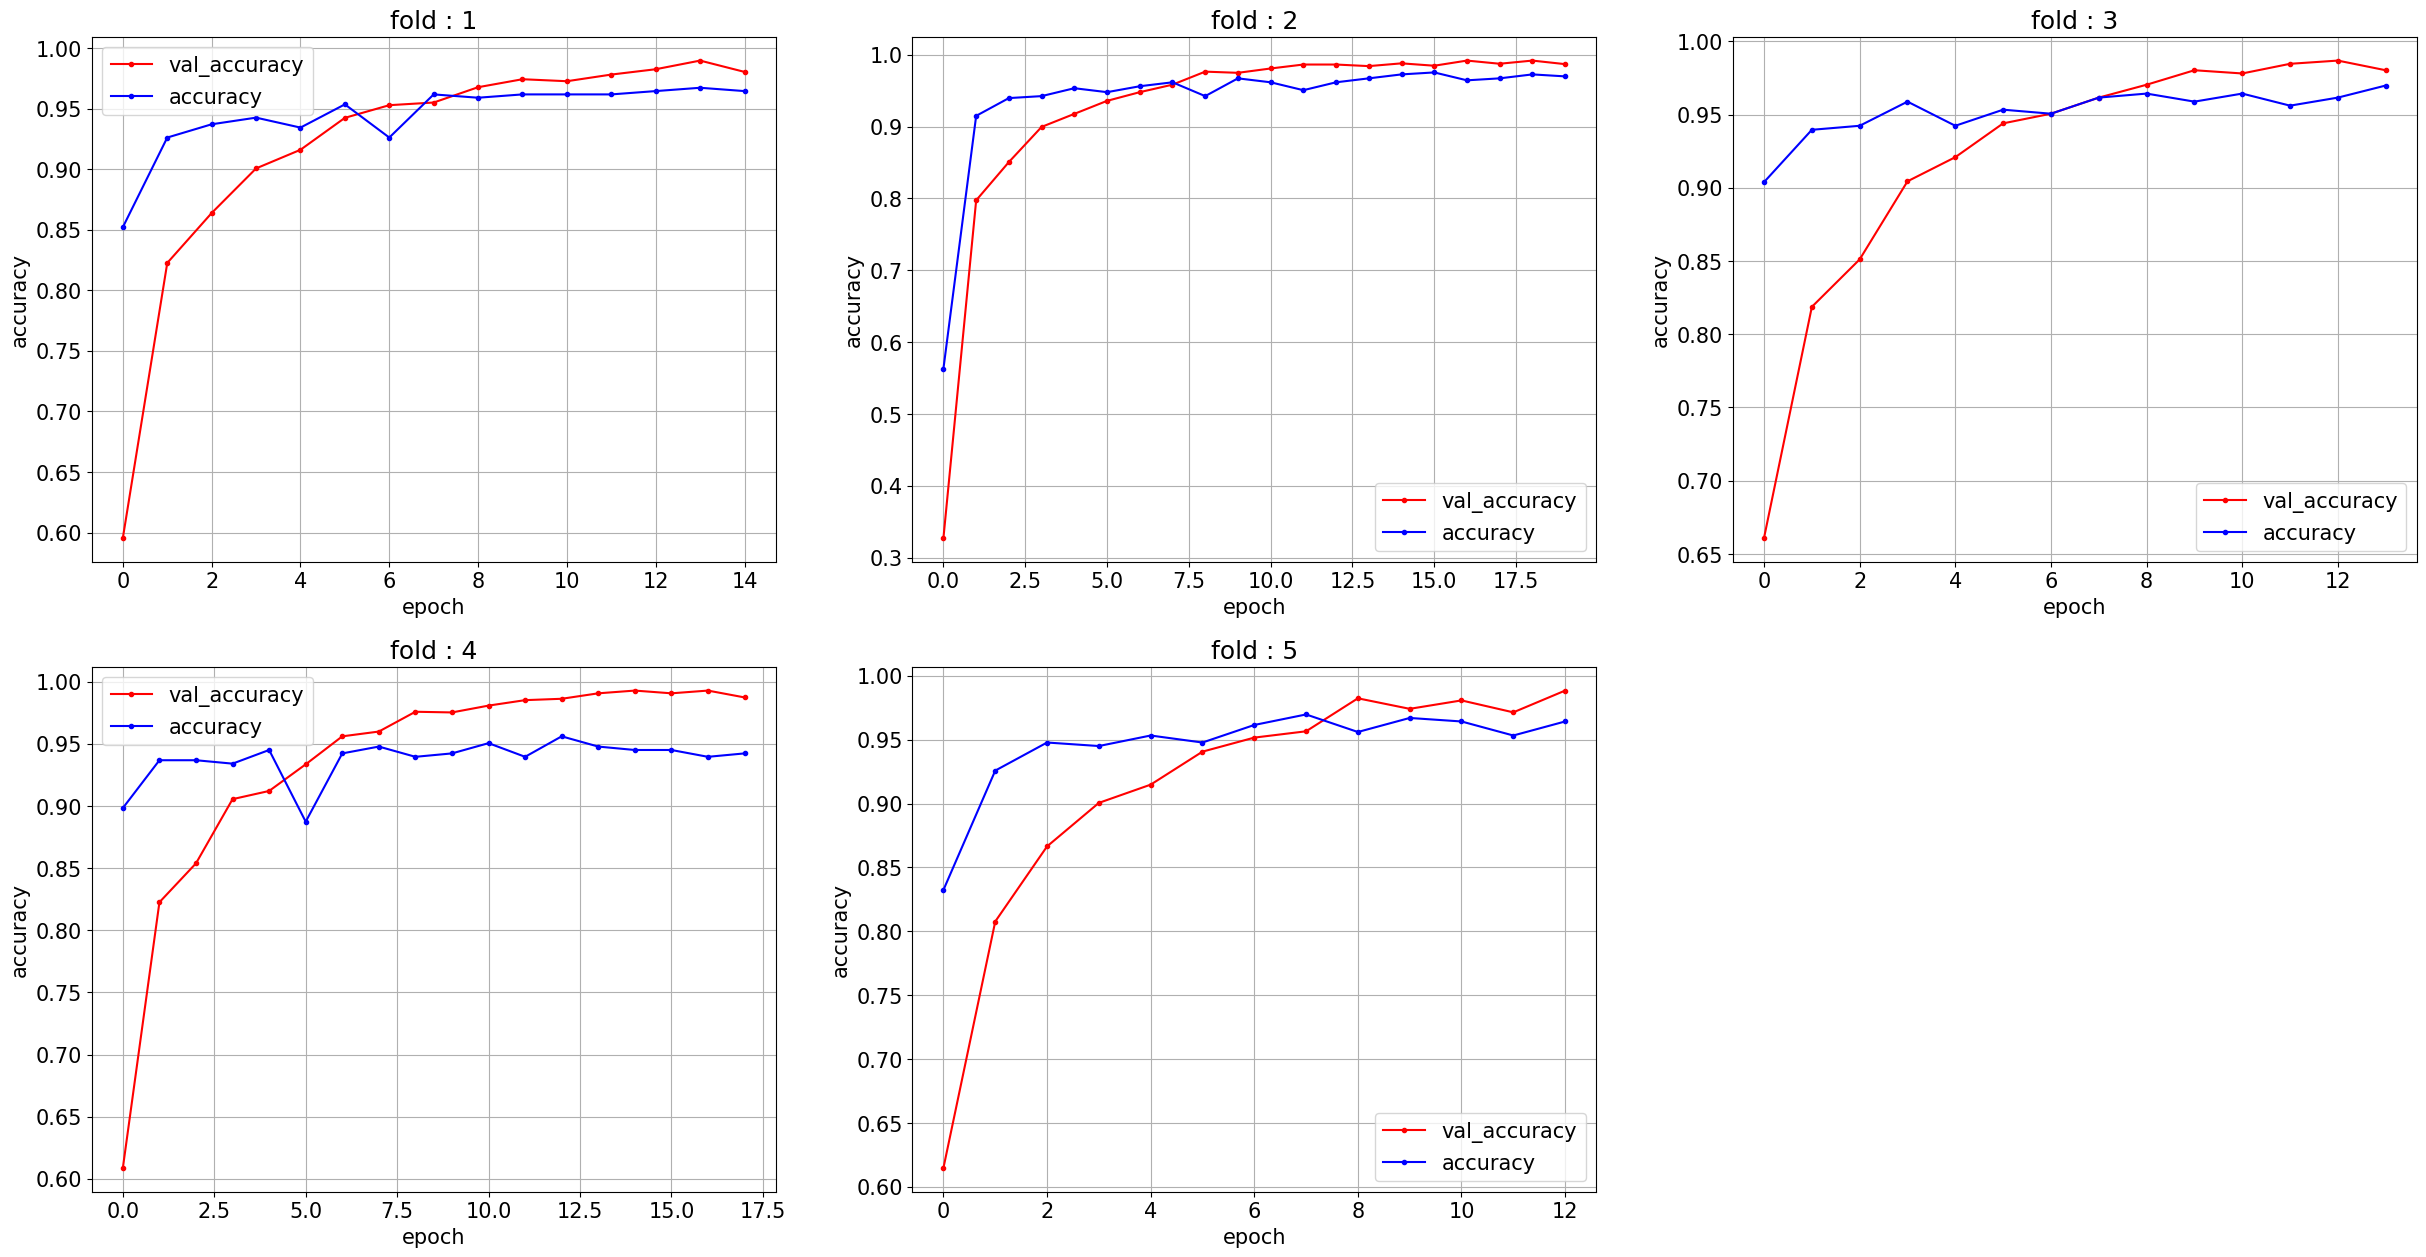

In [60]:
display_graph(histories, 'accuracy')

### EfficientNetB0 모델 학습

In [ ]:
kfold = KFold(n_splits=5)
valid_roc_auc_scores = []
probs =[]
for train_index, valid_index  in kfold.split(train):                # train 데이터 n_splits 만큼 분할
    cond = train.index.isin(train_index)                            # 분할된 train 데이터 지정
    cond1 = train.index.isin(valid_index)                           # 분할된 vaild 데이터 지정
    train_paths = train[cond].image_id.apply(format_path).values    # 이미지 경로 지정
    train_labels = train[cond].loc[:, 'healthy':].values            # 이미지 라벨 지정 
    valid_paths = train[cond1].image_id.apply(format_path).values
    valid_labels = train[cond1].loc[:, 'healthy':].values
    
    train_dataset = (                                               # 메소드 방식으로 dataset 지정
    tf.data.Dataset                                                 # tensorflow dataset 형식 호출
    .from_tensor_slices((train_paths, train_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .map(data_augment, num_parallel_calls=AUTO)
    .repeat()
    .shuffle(512)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
    )

    valid_dataset = (
        tf.data.Dataset
        .from_tensor_slices((valid_paths, valid_labels))
        .map(decode_image, num_parallel_calls=AUTO)
        .batch(BATCH_SIZE)
        .cache()
        .prefetch(AUTO)
    )

    test_dataset = (
        tf.data.Dataset
        .from_tensor_slices(test_paths)
        .map(decode_image, num_parallel_calls=AUTO)
        .batch(BATCH_SIZE)
    )

    
    model = tf.keras.Sequential([efn.EfficientNetB0(input_shape=(512, 512, 3), # EfficientNetB0 전이학습
                                                    weights='imagenet',        # imagent이 학습한 가중치 
                                                    include_top=False),        # 분류 학습을 하지 않음
                                GlobalAveragePooling2D(),                      # 2차원 만큼 차원 줄이기
                                Dense(train_labels.shape[1],
                                        activation='softmax')])                # softmax 활성화 함수로 출력
        
    model.compile(optimizer='adam',
                loss = 'categorical_crossentropy',
                metrics=['categorical_accuracy'])
    
    checkpointer = ModelCheckpoint(filepath='./{epoch:02d}.h5',monitor='val_roc_auc', mode='max')
                                                                            # filepath에 모델 저장
                                                                            # val_roc_auc 기준 저장
                                                                            # 정확도 기준이므로 max 높은값일떄 저장
    history = model.fit(train_dataset,                      # train 데이터셋 입력
                    epochs=EPOCHS,              
                    callbacks=[lr_schedule,checkpointer],
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=valid_dataset)          # valid 데이터셋 지정
    
    valid_roc_auc_scores.append(round(checkpointer.best, 4)) # roc_auc_scores 저장
    prob = model.predict(test_dataset, verbose=1)            # 모델 예측값 계산 , verbose=1 : 진행 출력
    probs.append(prob)                                       # 예측값 저장



INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

### 결과 그래프 시각화

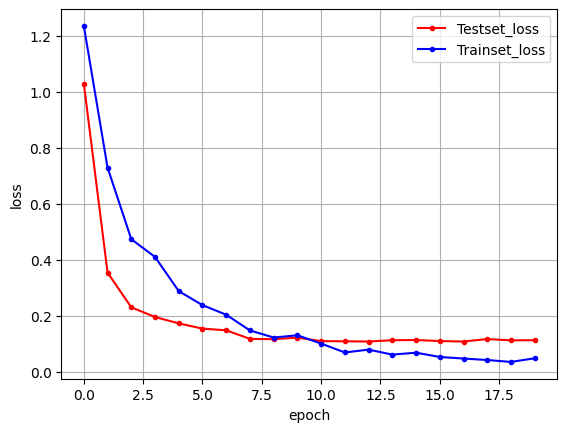

In [ ]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))          # epoch
plt.plot(x_len,y_vloss,marker='.',c='red',label='Testset_loss')
plt.plot(x_len,y_loss,marker='.',c='blue',label='Trainset_loss')

plt.legend(loc='best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

### 결과 저장

In [ ]:
prob_sum = np.zeros((1821,4))           # 합산 저장용 변수 선언
for prob in probs:
    prob_sum += prob
prob_avg = prob_sum/5
sub.loc[:, 'healthy':] = prob_avg
sub.to_csv('./data/submission_dnn.csv', index=False)
sub.head()

image_id   healthy  multiple_diseases      rust      scab
0   Test_0  0.002605       2.352395e-03  0.994908  0.000135
1   Test_1  0.000017       4.317682e-05  0.999926  0.000013
2   Test_2  0.000026       5.606744e-07  0.000005  0.999968
3   Test_3  0.999634       1.375297e-05  0.000222  0.000130
4   Test_4  0.003271       1.853664e-02  0.977464  0.000729

### Ensemble

In [ ]:
probs_dnn = pd.read_csv('./data/submission_dnn.csv')    # EfficientNetB0  결과값 파일 읽기
probs_enn = pd.read_csv('submission_dnn2.csv')          # DenseNet121 결과값 파일 읽기

In [ ]:
temp = np.zeros((1821,4))                               # 결과 값 합산 저장용 DataFrame 선언
temp_df = pd.DataFrame(temp,columns=['healthy', 'multiple_diseases', 'rust', 'scab'])
df = pd.concat([test,temp_df], axis=1)
ensemble_1, ensemble_2, ensemble_3 = [df]*3

In [ ]:
# Ensmeble의 voting 방법중 soft voting 으로 예측 결과 값들에 가중치를 두어 합산 하는 방식을 사용

ensemble_1.loc[:, 'healthy':] = 0.50*probs_dnn.loc[:,'healthy':] + 0.50*probs_enn.loc[:,'healthy':]
ensemble_2.loc[:, 'healthy':] = 0.25*probs_dnn.loc[:,'healthy':] + 0.75*probs_enn.loc[:,'healthy':]
ensemble_3.loc[:, 'healthy':] = 0.75*probs_dnn.loc[:,'healthy':] + 0.25*probs_enn.loc[:,'healthy':]

ensemble_1.to_csv('submission_ensemble_1.csv', index=False)
ensemble_2.to_csv('submission_ensemble_2.csv', index=False)
ensemble_3.to_csv('submission_ensemble_3.csv', index=False)

# DenseNet121 결과


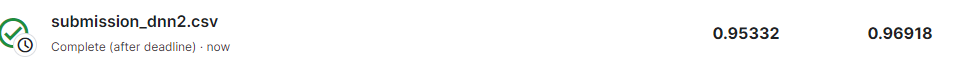

# EfficientNetB0 결과

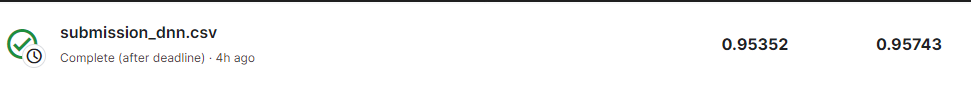

# Ensemble 결과

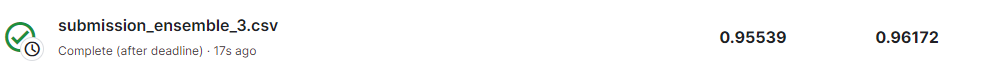

### Reference
Plant Pathology 2020 : EDA + Models
https://www.kaggle.com/code/tarunpaparaju/plant-pathology-2020-eda-models#Ending-note-
